# PIT for Flows in 1D
PIT idea based on https://arxiv.org/abs/2102.10473. 
Using the nflows library for flow implementations.

In [1]:
import torch
import torch.distributions as D

import matplotlib.pyplot as plt
import numpy as np

from nde.train import train
from nde.flows import construct_nsf, count_parameters
from plot import plot_pdf_1D, plot_cdf_1D, PP_plot_1D

In [2]:
# Target distributions 

# Gaussian 
mean = 2.
std = 1.
norm_dist = D.Normal(mean, std)

# Gaussian Mixture Model with 2 equally weighted gaussian distributions
mix = D.Categorical(torch.ones(2,))
comp = D.Normal(torch.FloatTensor([-2,2]), torch.rand(2,))
gmm_dist = D.MixtureSameFamily(mix, comp)

# Exponential distribution
rate = 1
exp_dist = D.Exponential(rate)

target_dists = {'gaussian': norm_dist, 'gmm': gmm_dist, 'exp': exp_dist}

In [3]:
# Get train and test samples 
target_dist = target_dists['exp']
x_samples = target_dist.sample((2000,))

test_size = int(0.1* len(x_samples))
train_size = len(x_samples) - test_size
train_set, test_set = torch.utils.data.random_split(x_samples, [train_size, test_size])
x_samples_train, x_samples_test = train_set[:].reshape(-1,1), test_set[:].reshape(-1,1)
print('NB training samples: ', x_samples_train.shape)
print('NB test samples: ', x_samples_test.shape)

# Define Flow: NSF (1 layer, 50 hidden features)
nsf = construct_nsf(x_samples, z_score_x = False, num_transforms=1)

# Count parameters
count_parameters(nsf)


NB training samples:  torch.Size([1800, 1])
NB test samples:  torch.Size([200, 1])


/opt/miniconda3/envs/nflows/lib/python3.9/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


11731

/Users/julialinhart/Documents/Code/github/sbc_flows/plot.py:9: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272478997/work/aten/src/ATen/native/RangeFactories.cpp:23.)
  eval_x = torch.linspace(x_i, x_f).reshape(-1,1)


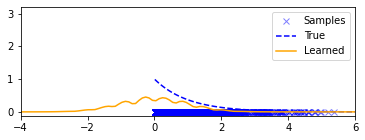

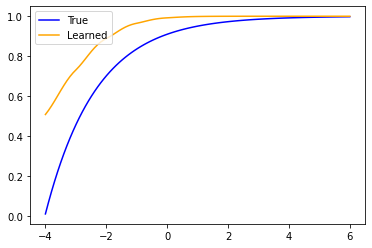

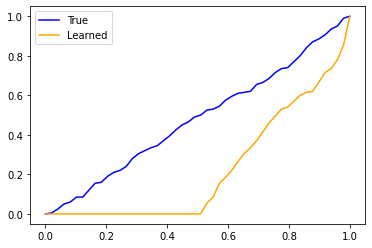

In [4]:
# PLOT TARGET VS. FLOW BEFORE TRAINING
plot_pdf_1D(target_dist, x_samples, flow=nsf, x_i=-4, x_f=6) # Density
plot_cdf_1D(target_dist,flow=nsf, x_i=-4, x_f=6) # CDF
PP_plot_1D(target_dist, x_samples_test, flow=nsf) # PP


In [5]:
# Train Flow
best_val_loss, epochs = train(nsf, x_samples_train, num_epochs=2000, batch_size=10, lr=0.005, validation=True, plot=False, epochs_until_converge=20)
epochs

38

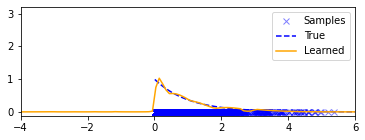

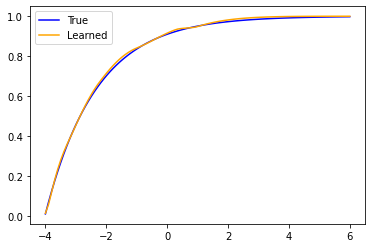

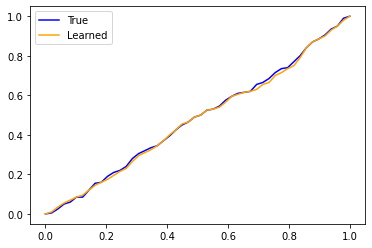

In [6]:
# PLOT TARGET VS. FLOW AFTER TRAINING
plot_pdf_1D(target_dist, x_samples, flow=nsf, x_i=-4, x_f=6) # Density
plot_cdf_1D(target_dist,flow=nsf, x_i=-4, x_f=6) # CDF
PP_plot_1D(target_dist, x_samples_test, flow=nsf) #PP